In [1]:
!nvidia-smi

Tue Jun  7 16:24:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.67       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:65:00.0 Off |                  N/A |
| 46%   50C    P8    50W / 370W |    147MiB / 24265MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    Off  | 00000000:B3:00.0 Off |                  N/A |
|  0%   

# Set up

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import seed
from collections import Counter
from datetime import datetime
import time
import os, sys
import tensorflow as tf
import warnings
from sklearn.decomposition import FastICA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, cohen_kappa_score, accuracy_score

warnings.filterwarnings("ignore")


gpus = tf.config.list_physical_devices(device_type='GPU')
tf.config.set_visible_devices(devices=gpus[0], device_type='GPU')

In [3]:
sys.path.append('/sleep_study/sleep_study')
import sleep_study as ss

# Useful Functions

In [4]:
def get_metrics(y, y_hat, verbose=True):
    cf = confusion_matrix(y, y_hat)
    ncf = 100*confusion_matrix(y, y_hat, normalize='true') # percentage
    precision,recall,mf,support = precision_recall_fscore_support(y,y_hat,average='macro')
    kp = cohen_kappa_score(y, y_hat)
    acc = 100*accuracy_score(y, y_hat) # percentage
    
    if verbose:
        print('\nConfusion Matrix')
        print(cf)
        print('\nNormalized Confusion Matrix')
        print(np.round(ncf))
        print('Accuracy: ', acc)
        print('Precision: ',precision)
        print('Recall: ',recall)
        print('Macro-F1 Score: ',mf)
        print('Kohen Kappa: ',kp)
        
    return {'confusion matrix': cf,
            'normalized confusion matrix': ncf,
            'accuracy': acc,
            'precision': precision,
            'recall': recall,
            'Macro-F1 Score': mf,
            'Kohen Kappa': kp}

In [5]:
def print_all_metrics(res, keys):
    ncf_name = 'normalized confusion matrix'
    
    for i, k in enumerate(keys):
        all_metrics = res[k]
        num_trials = len(all_metrics)
                
        means = pd.DataFrame(data = np.round(np.mean([all_metrics[rr][ncf_name] for rr in range(num_trials)], axis=0), 1), dtype='str')
        stds = pd.DataFrame(data = np.round(np.std([all_metrics[rr][ncf_name] for rr in range(num_trials)], axis=0), 1), dtype='str')
        tbl = (means + " " + u"\u00B1" + " " + stds).to_numpy()
        print(ncf_name)
        print(tbl) # I want normalized CF to print nicely with mean \pm standard deviation.

        for j in ['accuracy', 'precision', 'recall', 'Macro-F1 Score', 'Kohen Kappa']:
            m = str(np.round(np.mean([all_metrics[rr][j] for rr in range(num_trials)]), 3))
            s = str(np.round(np.std([all_metrics[rr][j] for rr in range(num_trials)]), 3))
            print(j, ":", m + " " + u"\u00B1" + " " + s)
        print( )

In [6]:
def get_npz_file_names(path):
    files = []
    with os.scandir(path) as it:
        for entry in it:
            if (entry.name.endswith('.npz') or entry.name.endswith('.NPZ')) and entry.is_file():
                files.append(path+entry.name)
    return files

In [7]:
def load_features(fn, verbose=False):   
    X = np.load(fn, allow_pickle=True)
    data, features, labels = X['data'], X["features"], X["labels"]
    if verbose:
        print(fn)
        print(features.shape, labels.shape)
        
    return data, features, labels

In [8]:
def train_test_classifier(idxs, data, clf, verbose=True):
    
    train_idx, test_idx = idxs
    X, y = data
    
    X_train, X_test = X[train_idx,:], X[test_idx,:]
    y_train, y_test = y[train_idx], y[test_idx]
    
    if verbose:
        print('train set class distribution', sorted(Counter(y_train).items()))
        print('test set class distribution', sorted(Counter(y_test).items()))

    t = time.time()
    clf.fit(X_train, y_train)

    if verbose:
        print('training took', np.around((time.time()-t)/60, 2), 'minutes.')

    y_hat = clf.predict(X_test)

    metrics = get_metrics(y_test, y_hat, verbose=False)
    
    y_pred = clf.predict_proba(X_test)

    plot_roc(np.eye(5)[y_test], y_pred)

    if verbose:
        print(metrics)
        print( )

    return metrics, y_hat

In [9]:
from sklearn.metrics import roc_curve, auc, roc_auc_score


def plot_roc(y_test, preds):
    fig = plt.figure(figsize=(8,6))
    
    for i in range(5):
        fpr, tpr, _ = roc_curve(y_test[:, i], preds[:, i])
        roc_auc = auc(fpr, tpr)
        # plot the roc curve for the model
        plt.plot(fpr, tpr, linestyle='solid', label='Label:{} AUC={:.3f}'.format(i, roc_auc))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.plot([0,1], [0,1], color='orange', linestyle='--')
#     filename = title + '.svg'
#     plt.savefig(filename)
    plt.show()

In [10]:
import pywt
def get_demo_wavelet_features(data, n=4, level=2):
    
    def get_stats(x, axis=-1):
        stats = []
        stats.extend(np.expand_dims(np.mean(x, axis), 0))
        stats.extend(np.expand_dims(np.std(x, axis), 0))
        stats.extend(np.expand_dims(np.min(x, axis),0))
        stats.extend(np.expand_dims(np.max(x, axis),0))

        return np.array(stats)   
    
    coeffs = pywt.wavedec(data, 'db%d' % n, level=level, axis=-1)

    # coeffs is a list of length (level+1)
    # coeffs[i] is an array of size (data.shape[0] == num events) by (data.shape[1] == num channels) by (-1)
    res = []

    for i in range(len(coeffs)):
        stats = get_stats(coeffs[i]) # this has (num stats) by (num events) by (num channels)
        res.extend(stats)    

    return np.array(res).transpose((1, 2, 0))

# Random Forest

In [10]:
all_eeg_wave = []
all_eog_wave = []
all_eeg_features = []
all_eog_features = []
all_labels = []

feature_files = get_npz_file_names('BCI_Data/Sleep_Data/')

for fn in feature_files:
    data, features, labels = load_features(fn)

#     if (features.shape[1:] != (9, 3840)):
#         continue
        
    all_eeg_wave.extend(data[:, :7])
    all_eog_wave.extend(data[:, 7:])
    all_eeg_features.extend(features[:, :7])
    all_eog_features.extend(features[:, 7:])

    all_labels.extend(labels)

all_eeg_wave = np.array(all_eeg_wave)
all_eog_wave = np.array(all_eog_wave)
all_eeg_features = np.array(all_eeg_features)
all_eog_features = np.array(all_eog_features)
all_labels = np.array(all_labels)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


# Raw EEG wave

train set class distribution [(0, 24425), (1, 8826), (2, 7677), (3, 4172), (4, 1490)]
test set class distribution [(0, 8142), (1, 2942), (2, 2559), (3, 1390), (4, 497)]
training took 2.39 minutes.


/home/jupyter-ryan1211/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'confusion matrix': array([[8124,   17,    1,    0,    0],
       [2795,  142,    5,    0,    0],
       [2507,   44,    7,    1,    0],
       [1370,    4,    3,   13,    0],
       [ 488,    5,    4,    0,    0]]), 'normalized confusion matrix': array([[9.97789241e+01, 2.08793908e-01, 1.22819946e-02, 0.00000000e+00,
        0.00000000e+00],
       [9.50033990e+01, 4.82664854e+00, 1.69952413e-01, 0.00000000e+00,
        0.00000000e+00],
       [9.79679562e+01, 1.71942165e+00, 2.73544353e-01, 3.90777648e-02,
        0.00000000e+00],
       [9.85611511e+01, 2.87769784e-01, 2.15827338e-01, 9.35251799e-01,
        0.00000000e+00],
       [9.81891348e+01, 1.00603622e+00, 8.04828974e-01, 0.00000000e+00,
        0.00000000e+00]]), 'accuracy': 53.354797166773984, 'precision': 0.4959837992763781, 'recall': 0.21162873757501358, 'Macro-F1 Score': 0.16151593758203017, 'Kohen Kappa': 0.03054790454549794}


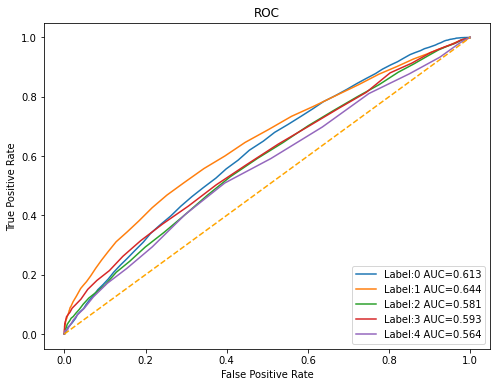

In [10]:
np.random.seed(2022)
clf = RandomForestClassifier(n_estimators=200, bootstrap=True, n_jobs=-1, class_weight='balanced')

X_train, X_test, y_train, y_test = train_test_split(all_eeg_wave, all_labels, stratify=all_labels)
X_train = np.reshape(X_train, (len(X_train), -1))
X_test = np.reshape(X_test, (len(X_test), -1))

print('train set class distribution', sorted(Counter(y_train).items()))
print('test set class distribution', sorted(Counter(y_test).items()))

t = time.time()
clf.fit(X_train, y_train)

print('training took', np.around((time.time()-t)/60, 2), 'minutes.')

y_hat = clf.predict(X_test)

metrics = get_metrics(y_test, y_hat, verbose=False)
print(metrics)

y_pred = clf.predict_proba(X_test)

plot_roc(np.eye(5)[y_test], y_pred)

## Apply fft to raw EEG wave

train set class distribution [(0, 24425), (1, 8826), (2, 7677), (3, 4172), (4, 1490)]
test set class distribution [(0, 8142), (1, 2942), (2, 2559), (3, 1390), (4, 497)]
training took 1.9 minutes.
{'confusion matrix': array([[8067,   74,    1,    0,    0],
       [2604,  337,    1,    0,    0],
       [2455,   84,   20,    0,    0],
       [1353,   36,    1,    0,    0],
       [ 490,    6,    1,    0,    0]]), 'normalized confusion matrix': array([[9.90788504e+01, 9.08867600e-01, 1.22819946e-02, 0.00000000e+00,
        0.00000000e+00],
       [8.85112169e+01, 1.14547927e+01, 3.39904827e-02, 0.00000000e+00,
        0.00000000e+00],
       [9.59359125e+01, 3.28253224e+00, 7.81555295e-01, 0.00000000e+00,
        0.00000000e+00],
       [9.73381295e+01, 2.58992806e+00, 7.19424460e-02, 0.00000000e+00,
        0.00000000e+00],
       [9.85915493e+01, 1.20724346e+00, 2.01207243e-01, 0.00000000e+00,
        0.00000000e+00]]), 'accuracy': 54.243399871217, 'precision': 0.39996152196849283, 'reca

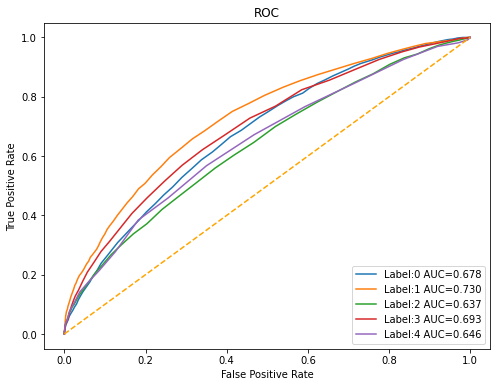

In [42]:
np.random.seed(2022)
clf = RandomForestClassifier(n_estimators=200, bootstrap=True, n_jobs=-1, class_weight='balanced')

X_train, X_test, y_train, y_test = train_test_split(all_eeg_wave, all_labels, stratify=all_labels)
X_train = np.abs(np.fft.fft(np.reshape(X_train, (len(X_train), -1))))
X_test = np.abs(np.fft.fft(np.reshape(X_test, (len(X_test), -1))))

print('train set class distribution', sorted(Counter(y_train).items()))
print('test set class distribution', sorted(Counter(y_test).items()))

t = time.time()
clf.fit(X_train, y_train)

print('training took', np.around((time.time()-t)/60, 2), 'minutes.')

y_hat = clf.predict(X_test)

metrics = get_metrics(y_test, y_hat, verbose=False)
print(metrics)

y_pred = clf.predict_proba(X_test)

plot_roc(np.eye(5)[y_test], y_pred)

## Get statistical features from raw EEG wave

train set class distribution [(0, 28687), (1, 10159), (2, 10146), (3, 4330), (4, 1751)]
test set class distribution [(0, 9562), (1, 3386), (2, 3382), (3, 1444), (4, 584)]
training took 2.22 minutes.
{'confusion matrix': array([[9304,  104,  124,   27,    3],
       [1861, 1419,   97,    8,    1],
       [2360,  231,  779,   10,    2],
       [1106,   73,   24,  235,    6],
       [ 490,   41,   42,    5,    6]]), 'normalized confusion matrix': array([[9.73018197e+01, 1.08763857e+00, 1.29679983e+00, 2.82367706e-01,
        3.13741895e-02],
       [5.49616066e+01, 4.19078559e+01, 2.86473715e+00, 2.36266982e-01,
        2.95333727e-02],
       [6.97811946e+01, 6.83027794e+00, 2.30337079e+01, 2.95683028e-01,
        5.91366056e-02],
       [7.65927978e+01, 5.05540166e+00, 1.66204986e+00, 1.62742382e+01,
        4.15512465e-01],
       [8.39041096e+01, 7.02054795e+00, 7.19178082e+00, 8.56164384e-01,
        1.02739726e+00]]), 'accuracy': 63.96666303518902, 'precision': 0.6527206325203734, '

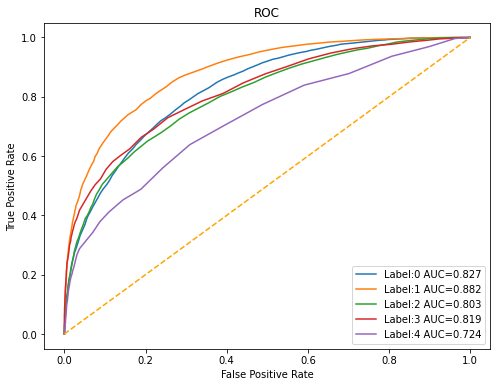

In [ ]:
np.random.seed(2022)
clf = RandomForestClassifier(n_estimators=200, bootstrap=True, n_jobs=-1, class_weight='balanced')

X_train, X_test, y_train, y_test = train_test_split(all_eeg_features, all_labels, stratify=all_labels)
X_train = np.reshape(X_train, (len(X_train), -1))
X_test = np.reshape(X_test, (len(X_test), -1))

print('train set class distribution', sorted(Counter(y_train).items()))
print('test set class distribution', sorted(Counter(y_test).items()))

t = time.time()
clf.fit(X_train, y_train)

print('training took', np.around((time.time()-t)/60, 2), 'minutes.')

y_hat = clf.predict(X_test)

metrics = get_metrics(y_test, y_hat, verbose=False)
print(metrics)

y_pred = clf.predict_proba(X_test)

plot_roc(np.eye(5)[y_test], y_pred)

# Apply ICA to remove eye-related artifact

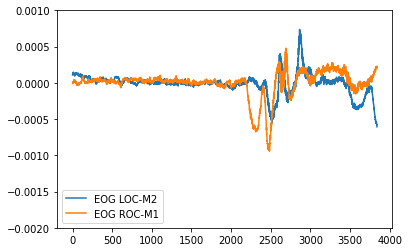

In [44]:
i = 7

EEG_CH_NAMES = [
        'EEG F4-M1',
        'EEG O2-M1',
        'EEG C4-M1',
        'EEG O1-M2',
        'EEG F3-M2',
        'EEG C3-M2',
        'EEG CZ-O1',
        'EOG LOC-M2',
        'EOG ROC-M1'
        ]

y_ticks = [-0.002,
 -0.0015,
 -0.001,
 -0.0005,
 0.0,
 0.0005,
 0.001]

for i in range(2):
    plt.plot(all_eog_wave[1][i].T, label=EEG_CH_NAMES[i+7])
    plt.yticks(y_ticks)
    plt.legend(loc=3)
plt.show()

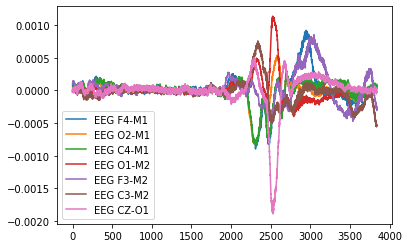

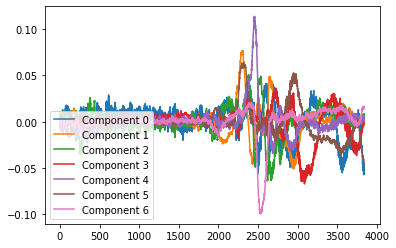

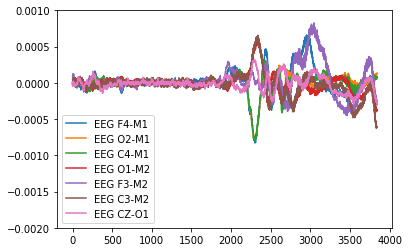

In [46]:
for i in range(7):
    plt.plot(all_eeg_wave[1, i].T, label=EEG_CH_NAMES[i])
    plt.yticks(y_ticks)
    plt.legend()
plt.show()

interval = 100

transformer = FastICA(n_components=7, random_state=0, tol=0.05)
a = transformer.fit_transform(all_eeg_wave[1].T)

for i in range(7):
    plt.plot(a[:, i], label='Component {}'.format(i))
    plt.legend(loc=3)
plt.show()

index0 = np.argmax(np.abs(all_eog_wave[1][0]))
index1 = np.argmax(np.abs(all_eog_wave[1][1]))

for j in range(7):
    if (np.argmax(np.abs(a[:, j])) < index0 + interval and np.argmax(np.abs(a[:, j])) > index0 - interval):
        a[:, j] = 0
    if (np.argmax(np.abs(a[:, j])) < index1 + interval and np.argmax(np.abs(a[:, j])) > index1 - interval):
        a[:, j] = 0
        
b = transformer.inverse_transform(a)
    
for i in range(7):
    plt.plot(b[:, i], label=EEG_CH_NAMES[i])
    plt.yticks(y_ticks)
    plt.legend(loc=3)
plt.show()

In [32]:
interval = 100

all_eeg_wave_ica = []
for i, signal in enumerate(all_eeg_wave):
    flag = 0
    
    index0 = np.argmax(np.abs(all_eog_wave[i][0]))
    
    try:
        index1 = np.argmax(np.abs(all_eog_wave[i][1]))
        flag = 1
    except:
        flag = 0
        
    transformer = FastICA(n_components=7, random_state=2022, tol=0.05)
    comps = transformer.fit_transform(all_eeg_wave[i].T)
    
    for j in range(7):
        if (np.argmax(np.abs(comps[:, j])) < index0 + interval and np.argmax(np.abs(comps[:, j])) > index0 - interval):
            comps[:, j] = 0
            
    if (flag == 1):
        for j in range(7):
            if (np.argmax(np.abs(comps[:, j])) < index1 + interval and np.argmax(np.abs(comps[:, j])) > index1 - interval):
                comps[:, j] = 0
        
    recon = transformer.inverse_transform(comps)

    all_eeg_wave_ica.append(recon)

all_eeg_wave_ica = np.array(all_eeg_wave_ica).transpose(0, 2, 1)

train set class distribution [(0, 24425), (1, 8826), (2, 7677), (3, 4172), (4, 1490)]
test set class distribution [(0, 8142), (1, 2942), (2, 2559), (3, 1390), (4, 497)]
training took 3.81 minutes.
{'confusion matrix': array([[8110,   26,    6,    0,    0],
       [2826,  113,    3,    0,    0],
       [2519,   32,    8,    0,    0],
       [1386,    3,    0,    1,    0],
       [ 490,    5,    2,    0,    0]]), 'normalized confusion matrix': array([[9.96069762e+01, 3.19331859e-01, 7.36919676e-02, 0.00000000e+00,
        0.00000000e+00],
       [9.60571040e+01, 3.84092454e+00, 1.01971448e-01, 0.00000000e+00,
        0.00000000e+00],
       [9.84368894e+01, 1.25048847e+00, 3.12622118e-01, 0.00000000e+00,
        0.00000000e+00],
       [9.97122302e+01, 2.15827338e-01, 0.00000000e+00, 7.19424460e-02,
        0.00000000e+00],
       [9.85915493e+01, 1.00603622e+00, 4.02414487e-01, 0.00000000e+00,
        0.00000000e+00]]), 'accuracy': 53.007083065035424, 'precision': 0.5162662180551323, 'r

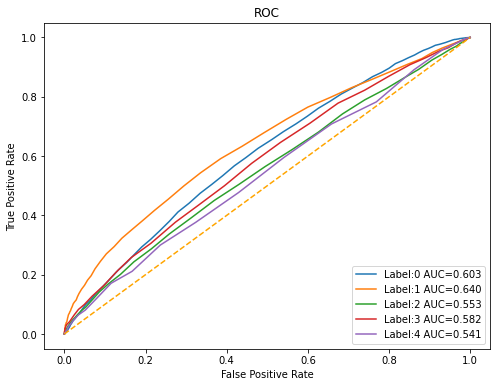

In [33]:
from sklearn.decomposition import FastICA
import warnings
warnings.filterwarnings("ignore")

np.random.seed(2022)
clf = RandomForestClassifier(n_estimators=200, bootstrap=True, n_jobs=-1, class_weight='balanced')

X_train_ica, X_test_ica, y_train, y_test = train_test_split(all_eeg_wave_ica, all_labels, stratify=all_labels)

X_train_ica = np.reshape(X_train_ica, (len(X_train_ica), -1))
X_test_ica = np.reshape(X_test_ica, (len(X_test_ica), -1))

print('train set class distribution', sorted(Counter(y_train).items()))
print('test set class distribution', sorted(Counter(y_test).items()))

t = time.time()
clf.fit(X_train_ica, y_train)

print('training took', np.around((time.time()-t)/60, 2), 'minutes.')

y_hat = clf.predict(X_test_ica)

metrics = get_metrics(y_test, y_hat, verbose=False)
print(metrics)

y_pred = clf.predict_proba(X_test_ica)

plot_roc(np.eye(5)[y_test], y_pred)

## Apply fft to artifact-free EEG wave

train set class distribution [(0, 24425), (1, 8826), (2, 7677), (3, 4172), (4, 1490)]
test set class distribution [(0, 8142), (1, 2942), (2, 2559), (3, 1390), (4, 497)]
training took 1.95 minutes.
{'confusion matrix': array([[8034,   92,   13,    2,    1],
       [2709,  225,    6,    2,    0],
       [2481,   62,   14,    2,    0],
       [1367,   22,    1,    0,    0],
       [ 491,    6,    0,    0,    0]]), 'normalized confusion matrix': array([[9.86735446e+01, 1.12994350e+00, 1.59665930e-01, 2.45639892e-02,
        1.22819946e-02],
       [9.20802175e+01, 7.64785860e+00, 2.03942896e-01, 6.79809653e-02,
        0.00000000e+00],
       [9.69519343e+01, 2.42282141e+00, 5.47088707e-01, 7.81555295e-02,
        0.00000000e+00],
       [9.83453237e+01, 1.58273381e+00, 7.19424460e-02, 0.00000000e+00,
        0.00000000e+00],
       [9.87927565e+01, 1.20724346e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]]), 'accuracy': 53.271088216355444, 'precision': 0.29945564622507137, '

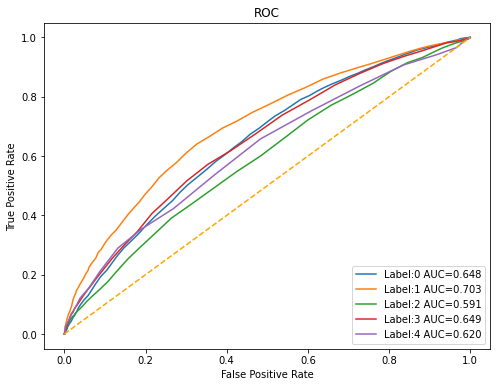

In [38]:
from sklearn.decomposition import FastICA
import warnings
warnings.filterwarnings("ignore")

np.random.seed(2022)
clf = RandomForestClassifier(n_estimators=200, bootstrap=True, n_jobs=-1, class_weight='balanced')

X_train_ica, X_test_ica, y_train, y_test = train_test_split(all_eeg_wave_ica, all_labels, stratify=all_labels)

X_train_ica = np.abs(np.fft.fft(np.reshape(X_train_ica, (len(X_train_ica), -1))))
X_test_ica = np.abs(np.fft.fft(np.reshape(X_test_ica, (len(X_test_ica), -1))))

print('train set class distribution', sorted(Counter(y_train).items()))
print('test set class distribution', sorted(Counter(y_test).items()))

t = time.time()
clf.fit(X_train_ica, y_train)

print('training took', np.around((time.time()-t)/60, 2), 'minutes.')

y_hat = clf.predict(X_test_ica)

metrics = get_metrics(y_test, y_hat, verbose=False)
print(metrics)

y_pred = clf.predict_proba(X_test_ica)

plot_roc(np.eye(5)[y_test], y_pred)

## Get statistical features from artifact-free EEG wave

train set class distribution [(0, 24425), (1, 8826), (2, 7677), (3, 4172), (4, 1490)]
test set class distribution [(0, 8142), (1, 2942), (2, 2559), (3, 1390), (4, 497)]
training took 0.11 minutes.
{'confusion matrix': array([[7987,  122,   26,    7,    0],
       [2157,  743,   38,    3,    1],
       [2221,  137,  198,    3,    0],
       [1287,   43,    5,   54,    1],
       [ 455,   18,   15,    6,    3]]), 'normalized confusion matrix': array([[9.80962908e+01, 1.49840334e+00, 3.19331859e-01, 8.59739622e-02,
        0.00000000e+00],
       [7.33174711e+01, 2.52549286e+01, 1.29163834e+00, 1.01971448e-01,
        3.39904827e-02],
       [8.67917155e+01, 5.35365377e+00, 7.73739742e+00, 1.17233294e-01,
        0.00000000e+00],
       [9.25899281e+01, 3.09352518e+00, 3.59712230e-01, 3.88489209e+00,
        7.19424460e-02],
       [9.15492958e+01, 3.62173038e+00, 3.01810865e+00, 1.20724346e+00,
        6.03621730e-01]]), 'accuracy': 57.85576303927882, 'precision': 0.6613983403650825, 're

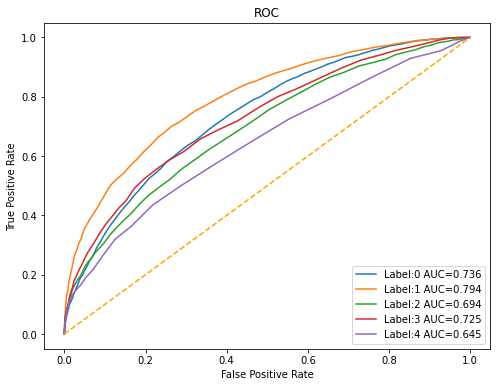

In [41]:
np.random.seed(2022)
clf = RandomForestClassifier(n_estimators=200, bootstrap=True, n_jobs=-1, class_weight='balanced')

all_eeg_ica_features = get_demo_wavelet_features(all_eeg_wave_ica)

X_train, X_test, y_train, y_test = train_test_split(all_eeg_ica_features, all_labels, stratify=all_labels)
X_train = np.reshape(X_train, (len(X_train), -1))
X_test = np.reshape(X_test, (len(X_test), -1))

print('train set class distribution', sorted(Counter(y_train).items()))
print('test set class distribution', sorted(Counter(y_test).items()))

t = time.time()
clf.fit(X_train, y_train)

print('training took', np.around((time.time()-t)/60, 2), 'minutes.')

y_hat = clf.predict(X_test)

metrics = get_metrics(y_test, y_hat, verbose=False)
print(metrics)

y_pred = clf.predict_proba(X_test)

plot_roc(np.eye(5)[y_test], y_pred)

# Apply ASR to remove artifact

In [58]:
from meegkit.asr import ASR
from meegkit.utils.matrix import sliding_window 

EEG_CH_NAMES = [
        'EEG F4-M1',
        'EEG O2-M1',
        'EEG C4-M1',
        'EEG O1-M2',
        'EEG F3-M2',
        'EEG C3-M2',
        'EEG CZ-O1',
        'EOG LOC-M2',
        'EOG ROC-M1'
        ]

y_ticks = [-0.002,
 -0.0015,
 -0.001,
 -0.0005,
 0.0,
 0.0005,
 0.001]

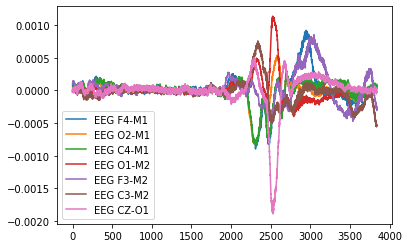

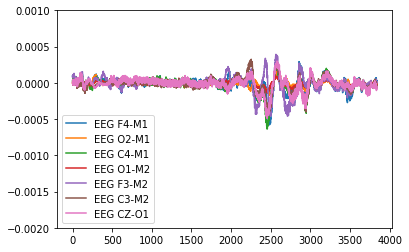

In [62]:
for i in range(7):
    plt.plot(all_eeg_wave[1, i].T, label=EEG_CH_NAMES[i])
    plt.yticks(y_ticks)
    plt.legend()
plt.show()

interval = 100

_, sample_mask = asr.fit(all_eeg_wave[1, :, train_idx].T)

# Apply filter using sliding (non-overlapping) windows
X = sliding_window(all_eeg_wave[1], window=int(sfreq), step=int(sfreq))
Y = np.zeros_like(X)
for i in range(X.shape[1]):
    Y[:, i, :] = asr.transform(X[:, i, :])

y = Y.reshape(7, -1)
    
for i in range(7):
    plt.plot(y[i].T, label=EEG_CH_NAMES[i])
    plt.yticks(y_ticks)
    plt.legend(loc=3)
plt.show()

In [71]:
sfreq = 128

asr = ASR(method='euclid')

all_eeg_wave_ASR = []

train_idx = np.arange(0 * sfreq, 3 * sfreq, dtype=int)

for i, wave in enumerate(all_eeg_wave):
    try:
        _, sample_mask = asr.fit(wave[:, train_idx])

        # Apply filter using sliding (non-overlapping) windows
        X = sliding_window(wave, window=int(sfreq), step=int(sfreq))
        Y = np.zeros_like(X)
        for i in range(X.shape[1]):
            Y[:, i, :] = asr.transform(X[:, i, :])

        all_eeg_wave_ASR.append(Y.reshape(7, -1))
    
    except:
        all_eeg_wave_ASR.append(wave)
        
all_eeg_wave_ASR = np.array(all_eeg_wave_ASR)

train set class distribution [(0, 24425), (1, 8826), (2, 7677), (3, 4172), (4, 1490)]
test set class distribution [(0, 8142), (1, 2942), (2, 2559), (3, 1390), (4, 497)]
training took 3.34 minutes.
{'confusion matrix': array([[8133,    8,    1,    0,    0],
       [2848,   91,    3,    0,    0],
       [2518,   35,    6,    0,    0],
       [1384,    5,    1,    0,    0],
       [ 489,    5,    3,    0,    0]]), 'normalized confusion matrix': array([[9.98894620e+01, 9.82559568e-02, 1.22819946e-02, 0.00000000e+00,
        0.00000000e+00],
       [9.68048946e+01, 3.09313392e+00, 1.01971448e-01, 0.00000000e+00,
        0.00000000e+00],
       [9.83978116e+01, 1.36772177e+00, 2.34466589e-01, 0.00000000e+00,
        0.00000000e+00],
       [9.95683453e+01, 3.59712230e-01, 7.19424460e-02, 0.00000000e+00,
        0.00000000e+00],
       [9.83903421e+01, 1.00603622e+00, 6.03621730e-01, 0.00000000e+00,
        0.00000000e+00]]), 'accuracy': 52.99420476497102, 'precision': 0.31791894353369765, 'r

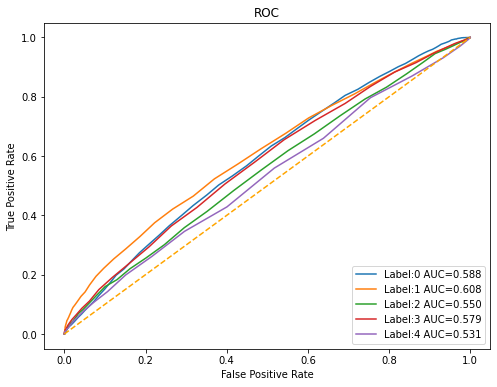

In [86]:
import warnings
warnings.filterwarnings("ignore")

np.random.seed(2022)
clf = RandomForestClassifier(n_estimators=200, bootstrap=True, n_jobs=-1, class_weight='balanced')

X_train_asr, X_test_asr, y_train, y_test = train_test_split(all_eeg_wave_ASR, all_labels, stratify=all_labels)

X_train_asr = np.reshape(X_train_asr, (len(X_train_asr), -1))
X_test_asr = np.reshape(X_test_asr, (len(X_test_asr), -1))

print('train set class distribution', sorted(Counter(y_train).items()))
print('test set class distribution', sorted(Counter(y_test).items()))

t = time.time()
clf.fit(X_train_asr, y_train)

print('training took', np.around((time.time()-t)/60, 2), 'minutes.')

y_hat = clf.predict(X_test_asr)

metrics = get_metrics(y_test, y_hat, verbose=False)
print(metrics)

y_pred = clf.predict_proba(X_test_asr)

plot_roc(np.eye(5)[y_test], y_pred)

# Apply fft to wave after ASR

train set class distribution [(0, 24425), (1, 8826), (2, 7677), (3, 4172), (4, 1490)]
test set class distribution [(0, 8142), (1, 2942), (2, 2559), (3, 1390), (4, 497)]
training took 1.86 minutes.
{'confusion matrix': array([[8095,   42,    5,    0,    0],
       [2734,  207,    1,    0,    0],
       [2489,   57,   13,    0,    0],
       [1379,   11,    0,    0,    0],
       [ 493,    3,    1,    0,    0]]), 'normalized confusion matrix': array([[9.94227463e+01, 5.15843773e-01, 6.14099730e-02, 0.00000000e+00,
        0.00000000e+00],
       [9.29299796e+01, 7.03602991e+00, 3.39904827e-02, 0.00000000e+00,
        0.00000000e+00],
       [9.72645565e+01, 2.22743259e+00, 5.08010942e-01, 0.00000000e+00,
        0.00000000e+00],
       [9.92086331e+01, 7.91366906e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [9.91951710e+01, 6.03621730e-01, 2.01207243e-01, 0.00000000e+00,
        0.00000000e+00]]), 'accuracy': 53.54153251770766, 'precision': 0.3659582784726794, 're

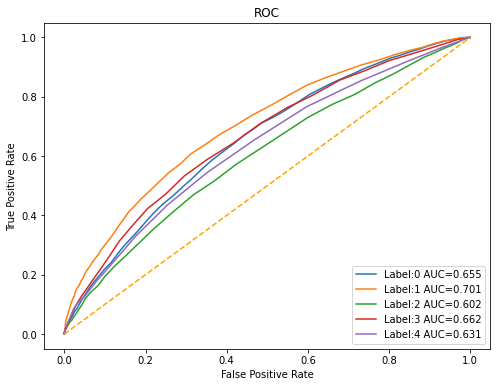

In [87]:
import warnings
warnings.filterwarnings("ignore")

np.random.seed(2022)
clf = RandomForestClassifier(n_estimators=200, bootstrap=True, n_jobs=-1, class_weight='balanced')

X_train_asr, X_test_asr, y_train, y_test = train_test_split(all_eeg_wave_ASR, all_labels, stratify=all_labels)

X_train_asr = np.abs(np.fft.fft(np.reshape(X_train_asr, (len(X_train_asr), -1))))
X_test_asr = np.abs(np.fft.fft(np.reshape(X_test_asr, (len(X_test_asr), -1))))

print('train set class distribution', sorted(Counter(y_train).items()))
print('test set class distribution', sorted(Counter(y_test).items()))

t = time.time()
clf.fit(X_train_asr, y_train)

print('training took', np.around((time.time()-t)/60, 2), 'minutes.')

y_hat = clf.predict(X_test_asr)

metrics = get_metrics(y_test, y_hat, verbose=False)
print(metrics)

y_pred = clf.predict_proba(X_test_asr)

plot_roc(np.eye(5)[y_test], y_pred)

# Get statistical features from ASR wave

train set class distribution [(0, 24425), (1, 8826), (2, 7677), (3, 4172), (4, 1490)]
test set class distribution [(0, 8142), (1, 2942), (2, 2559), (3, 1390), (4, 497)]
training took 0.11 minutes.
{'confusion matrix': array([[8026,   68,   39,    8,    1],
       [2239,  665,   36,    2,    0],
       [2180,  138,  239,    2,    0],
       [1294,   31,    6,   59,    0],
       [ 456,   12,   14,    9,    6]]), 'normalized confusion matrix': array([[9.85752886e+01, 8.35175633e-01, 4.78997789e-01, 9.82559568e-02,
        1.22819946e-02],
       [7.61046907e+01, 2.26036710e+01, 1.22365738e+00, 6.79809653e-02,
        0.00000000e+00],
       [8.51895272e+01, 5.39273154e+00, 9.33958578e+00, 7.81555295e-02,
        0.00000000e+00],
       [9.30935252e+01, 2.23021583e+00, 4.31654676e-01, 4.24460432e+00,
        0.00000000e+00],
       [9.17505030e+01, 2.41448692e+00, 2.81690141e+00, 1.81086519e+00,
        1.20724346e+00]]), 'accuracy': 57.92015453960077, 'precision': 0.7206386382302237, 're

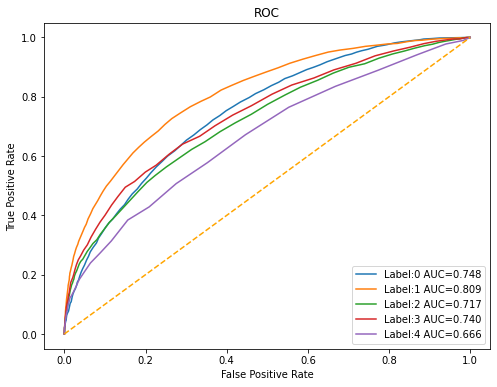

In [88]:
np.random.seed(2022)
clf = RandomForestClassifier(n_estimators=200, bootstrap=True, n_jobs=-1, class_weight='balanced')

all_eeg_asr_features = get_demo_wavelet_features(all_eeg_wave_ASR)

X_train, X_test, y_train, y_test = train_test_split(all_eeg_asr_features, all_labels, stratify=all_labels)

X_train = np.reshape(X_train, (len(X_train), -1))
X_test = np.reshape(X_test, (len(X_test), -1))

print('train set class distribution', sorted(Counter(y_train).items()))
print('test set class distribution', sorted(Counter(y_test).items()))

t = time.time()
clf.fit(X_train, y_train)

print('training took', np.around((time.time()-t)/60, 2), 'minutes.')

y_hat = clf.predict(X_test)

metrics = get_metrics(y_test, y_hat, verbose=False)
print(metrics)

y_pred = clf.predict_proba(X_test)

plot_roc(np.eye(5)[y_test], y_pred)

# CNN

In [11]:
all_eeg_wave = []
all_eog_wave = []
all_eeg_features = []
all_eog_features = []
all_labels = []

feature_files = get_npz_file_names('BCI_Data/Sleep_Data/')

for fn in feature_files:
    data, features, labels = load_features(fn)

#     if (features.shape[1:] != (9, 3840)):
#         continue
        
    all_eeg_wave.extend(data[:, :7])
    all_eog_wave.extend(data[:, 7:])
    all_eeg_features.extend(features[:, :7])
    all_eog_features.extend(features[:, 7:])

    all_labels.extend(labels)

all_eeg_wave = np.array(all_eeg_wave)
all_eog_wave = np.array(all_eog_wave)
all_eeg_features = np.array(all_eeg_features)
all_eog_features = np.array(all_eog_features)
all_labels = np.array(all_labels)

In [12]:
interval = 100

all_eeg_wave_ica = []
for i, signal in enumerate(all_eeg_wave):
    flag = 0
    
    index0 = np.argmax(np.abs(all_eog_wave[i][0]))
    
    try:
        index1 = np.argmax(np.abs(all_eog_wave[i][1]))
        flag = 1
    except:
        flag = 0
        
    transformer = FastICA(n_components=7, random_state=2022, tol=0.05)
    comps = transformer.fit_transform(all_eeg_wave[i].T)
    
    for j in range(7):
        if (np.argmax(np.abs(comps[:, j])) < index0 + interval and np.argmax(np.abs(comps[:, j])) > index0 - interval):
            comps[:, j] = 0
            
    if (flag == 1):
        for j in range(7):
            if (np.argmax(np.abs(comps[:, j])) < index1 + interval and np.argmax(np.abs(comps[:, j])) > index1 - interval):
                comps[:, j] = 0
        
    recon = transformer.inverse_transform(comps)

    all_eeg_wave_ica.append(recon)

all_eeg_wave_ica = np.array(all_eeg_wave_ica).transpose(0, 2, 1)

In [13]:
from sklearn.utils import class_weight 
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(all_labels), y=all_labels)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.3814904658089477,
 1: 1.0557443915703604,
 2: 1.2137553731926534,
 3: 2.2337288745055734,
 4: 6.252642174131857}

In [14]:
X_train, X_test, y_train, y_test = train_test_split(all_eeg_wave_ica, all_labels, stratify=all_labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train)

y_train = np.eye(5)[y_train]
y_val = np.eye(5)[y_val]
y_test = np.eye(5)[y_test]

X_train = np.reshape(X_train, (len(X_train), 7, 3840, 1))
X_val = np.reshape(X_val, (len(X_val), 7, 3840, 1))
X_test = np.reshape(X_test, (len(X_test), 7, 3840, 1))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 7, 3840, 8)        264       
_________________________________________________________________
batch_normalization_12 (Batc (None, 7, 3840, 8)        32        
_________________________________________________________________
depthwise_conv2d_4 (Depthwis (None, 1, 3840, 32)       224       
_________________________________________________________________
batch_normalization_13 (Batc (None, 1, 3840, 32)       128       
_________________________________________________________________
activation_8 (Activation)    (None, 1, 3840, 32)       0         
_________________________________________________________________
average_pooling2d_8 (Average (None, 1, 1280, 32)       0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 1, 1280, 32)      

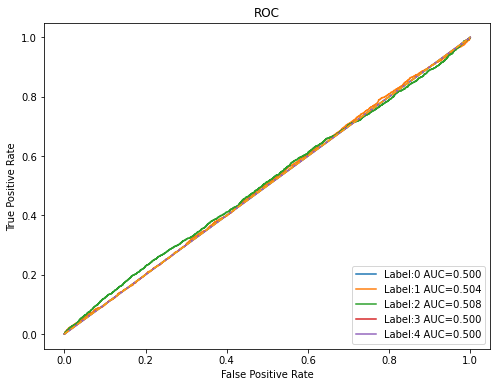

In [19]:
from tensorflow.keras import backend as K
import tensorflow.keras as keras

def square(x):
    return K.square(x)

def log(x):
    return K.log(K.clip(x, min_value = 1e-7, max_value = 10000))  

F1, D = 8, 4
F2 = F1*D

model = keras.models.Sequential()
model.add(keras.layers.InputLayer((7, 3840, 1)))

model.add(keras.layers.Conv2D(F1, (1, 32), padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.DepthwiseConv2D((7, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = tf.keras.constraints.max_norm(1.)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('elu'))
model.add(keras.layers.AveragePooling2D(pool_size=(1, 3)))
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.SeparableConv2D(F2, (1, 16), use_bias = False, padding = 'same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('elu'))
model.add(keras.layers.AveragePooling2D(pool_size=(1, 3)))
model.add(keras.layers.Dropout(0.1))


model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='AUC')

model.summary()

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = [tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_auc',
    mode='max',
    save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]

history = model.fit(X_train, y_train, epochs=100, batch_size=32, class_weight=class_weights, validation_data=(X_val, y_val), callbacks=model_checkpoint_callback)

model.load_weights('/tmp/checkpoint')

y_pred = model.predict(X_test)

plot_roc(y_test, y_pred)

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 7, 64)             15728704  
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 7, 32)             65568     
_________________________________________________________________
global_max_pooling1d_16 (Glo (None, 32)                0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_58 (Dense)             (None, 5)                 325       
Total params: 15,796,709
Trainable params: 15,796,709
Non-trainable params: 0
_________________________________________

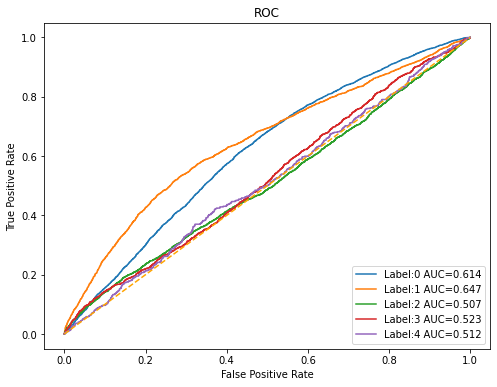

In [49]:
X_train, X_test, y_train, y_test = train_test_split(all_eeg_wave, all_labels, stratify=all_labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train)

y_train = np.eye(5)[y_train]
y_val = np.eye(5)[y_val]
y_test = np.eye(5)[y_test]

import tensorflow.keras as keras

model = keras.models.Sequential()
model.add(keras.layers.InputLayer((7, 3840)))

model.add(keras.layers.Conv1D(filters=64, kernel_size=64, padding="same", activation='relu'))
# model.add(keras.layers.BatchNormalization())
# model.add(keras.layers.ReLU())

model.add(keras.layers.Conv1D(filters=32, kernel_size=32, padding="same", activation='relu'))
# model.add(keras.layers.BatchNormalization())
# model.add(keras.layers.ReLU())

# model.add(keras.layers.Conv1D(filters=16, kernel_size=16, padding="same", activation='relu'))
# model.add(keras.layers.BatchNormalization())
# model.add(keras.layers.ReLU())

model.add(keras.layers.GlobalMaxPooling1D())
# model.add(keras.layers.Flatten())

model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(5, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics='AUC')

model.summary()

checkpoint_filepath = '/tmp/checkpoint_CNN'
model_checkpoint_callback = [tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_auc',
    mode='max',
    save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]

history = model.fit(X_train, y_train, epochs=100, batch_size=16, class_weight=class_weights, validation_data=(X_val, y_val), callbacks=model_checkpoint_callback)

model.load_weights('/tmp/checkpoint_CNN')

y_pred = model.predict(X_test)

plot_roc(y_test, y_pred)